In [36]:
import torch
import matplotlib.pyplot as plt
import time
plt.ion()

plots = True
# Illuatrate
# N = 10         # number of training points.
# n = 50         # number of test points.

# Go Crazy
N = 2000
n = 10000

start = time.time()

In [37]:
""" This is code for simple GP regression. It assumes a zero mean GP Prior """


# This is the true unknown function we are trying to approximate
f = lambda x: torch.sin(0.9*x).view(-1)
#f = lambda x: (0.25*(x**2)).flatten()


# Define the kernel
def kernel(a, b):
    """ GP squared exponential kernel """
    kernelParameter = 0.1
    sqdist = torch.sum(a**2, 1).view(-1,1) + torch.sum(b**2,1) - 2*torch.matmul(a, b.t())
    return torch.exp(-.5 * (1/kernelParameter) * sqdist)

s = 0.005    # noise variance.

# Sample some input points and noisy versions of the function evaluated at
# these points. 
X = torch.Tensor(N, 1).uniform_(-5, 5).cuda()
y = f(X) + s*torch.randn(N).cuda()

K = kernel(X, X)
# q, r = torch.qr(K + s*torch.eye(N).cuda())
# L = torch.tril(torch.matmul(q.cuda(), r.cuda()))
a = K + s*torch.eye(N).cuda()
L = torch.potrf(a, False)

# points we're going to make predictions at.
Xtest = torch.linspace(-5, 5, n).view(-1,1).cuda()

# compute the mean at our test points.
Lk, _ = torch.gesv(kernel(X, Xtest), L)
lk2, _ = torch.gesv(y.view(-1, 1), L)
mu = torch.matmul(Lk.t(), lk2).view(-1)

# compute the variance at our test points.
K_ = kernel(Xtest, Xtest)
s2 = torch.diag(K_) - torch.sum(Lk**2, 0)
s = torch.sqrt(s2)

print(time.time() - start)

0.18193793296813965


0.22501492500305176


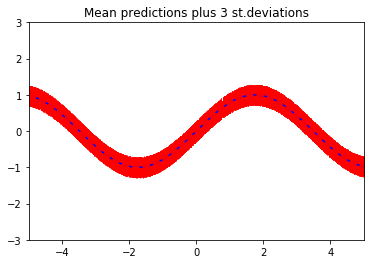

In [38]:
# PLOTS:
if plots:
    plt.figure(1)
    plt.clf()
    plt.plot(X.cpu().numpy(), y.cpu().numpy(), 'r+', ms=20)
    plt.plot(Xtest.cpu().numpy(), f(Xtest).cpu().numpy(), 'b-')
    plt.gca().fill_between(Xtest.cpu().numpy().flat, 
                           mu.cpu().numpy()-3*s.cpu().numpy(), 
                           mu.cpu().numpy()+3*s.cpu().numpy(), 
                           color="#dddddd")
    plt.plot(Xtest.cpu().numpy(), mu.cpu().numpy(), 'r--', lw=2)
    plt.title('Mean predictions plus 3 st.deviations')
    plt.axis([-5, 5, -3, 3])
print(time.time() - start)

0.5395712852478027


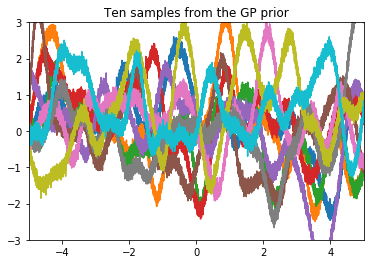

In [39]:
# draw samples from the prior at our test points.
a = K_ + 0.01*torch.eye(n).cuda()
L = torch.potrf(a, False)
f_prior = torch.matmul(L, torch.randn(n, 10).cuda())

if plots:
    plt.figure(2)
    plt.clf()
    plt.plot(Xtest.cpu().numpy(), f_prior.cpu().numpy())
    plt.title('Ten samples from the GP prior')
    plt.axis([-5, 5, -3, 3])

print(time.time() - start)

0.9908502101898193


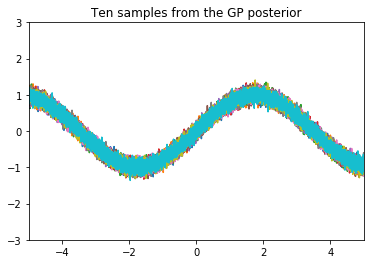

In [40]:
# draw samples from the posterior at our test points.
a = K_ + 0.01*torch.eye(n).cuda() - torch.matmul(Lk.t(), Lk)
L = torch.potrf(a, False)
f_post = mu.view(-1,1) + torch.matmul(L, torch.randn(n, 10).cuda())

if plots:
    plt.figure(3)
    plt.clf()
    plt.plot(Xtest.cpu().numpy(), f_post.cpu().numpy())
    plt.title('Ten samples from the GP posterior')
    plt.axis([-5, 5, -3, 3])

print(time.time() - start)